In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_GPU import ZSTL


In [ ]:
sineRegress = FuncRecursiveNet([
        FLinearLayer(40, True),
        FActivation(F.relu),
        FLinearLayer(40, True),
        FActivation(F.relu),
        FLinearLayer(1, True)
    ])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
kb_size = 10
train_size = 90

In [ ]:
filename = 'sineWave_xl.p'
with open(filename, 'rb') as f:
    dataset = pickle.load(f)
total_len = len(dataset)
test_size = total_len - kb_size - train_size

flatted_param, shape_record = utils.flattenParam(dataset[0])
print(shape_record)

indx = [ x for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
test_indx = temp
print(len(test_indx))

support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])

support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=int(train_size/5), shuffle=True)
test_loader = DataLoader(test_data, batch_size=int(test_size), shuffle=True)

support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()

{0: [(40, 1)], 1: [(40,)], 2: [(40, 40)], 3: [(40,)], 4: [(1, 40)], 5: [(1,)]}
10
90
44


tensor([0.4000, 1.0000, 4.3197])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=2.5451861992498766e-15


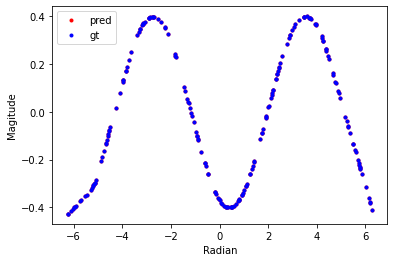

In [ ]:
#test visualization and rehspae uitls
item = [support_a[0,:].float(), support_w[0,:].float(), support_x[0,:].float(), support_y[0,:].float()]
utils.taskVisualize(item, sineRegress, shape_record)

In [ ]:

support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
print(support_a.size())
dm = support_a.size()[0]

param_dict = {}
param_dict['rho'] = 1e-5
param_dict['mu'] = 0.0001
param_dict['loss'] = 'mse'
param_dict['outer lr'] = 5e-4
param_dict['align lr'] = 5e-4
param_dict['dm'] = dm
param_dict['d'] = 1761
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Softmax'


ZSTL_model = ZSTL(support_w, support_a,  sineRegress, param_dict, device=device)

torch.Size([3, 10])
softmax selected


test  torch.Size([3, 44]) torch.Size([1761, 44]) torch.Size([44, 200, 1]) torch.Size([44, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 0.6983900993046436; align loss 0.08313776552677155
1/4000 o_loss 0.6576931312576764; m train metric 0.6505584211813079; m test metric 0.6991376241838391; align loss  0.07375526428222656
100/4000 o_loss 0.7990795105385283; m train metric 0.7925776917901304; m test metric 0.6833309407599948; align loss  0.06779026985168457
200/4000 o_loss 0.7256038877078228; m train metric 0.7160855289548635; m test metric 0.5010884956202724; align loss  0.06153322756290436
300/4000 o_loss 0.34470826775456465; m train metric 0.336100152383248; m test metric 0.28395632336932153; align loss  0.0616428479552269
400/4000 o_loss 0.23994343526040512; m train metric 0.23107820314665634; m test metric 0.18397745646705682; align loss  0.06026870757341385
500/4000 o_loss 0.16570089653962186; m train metric 0.1568181278804938; m test metric 0.1420472045429051; al

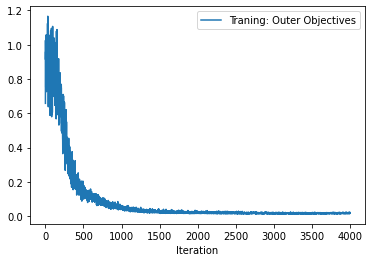

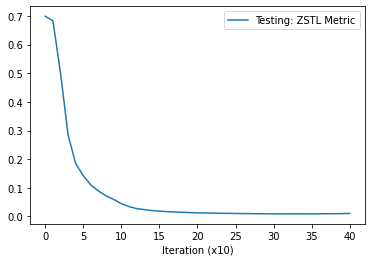

0

In [ ]:
ZSTL_model.train(train_loader, test_loader, max_iter=4000)

In [ ]:
test_batch = next(iter(test_loader))
test_a, test_w, test_x, test_y = test_batch[0].float().to(ZSTL_model.device), test_batch[1].float(), \
    test_batch[2].float(), test_batch[3].float()
test_a = test_a.squeeze().t()
test_w = test_w.squeeze().t()

test_w_pred = ZSTL_model.task_transfer(test_a)
test_batch_size = test_w_pred.size()[1]


tensor([1.6000, 1.0000, 4.7124], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.5pi, pred loss=0.004709039349108934


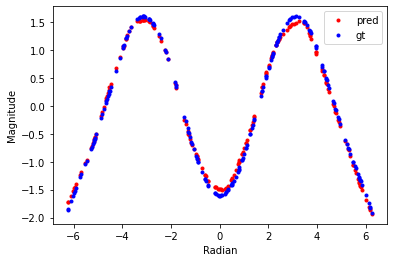

tensor([1., 1., 0.], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.0pi, pred loss=0.014300817623734474


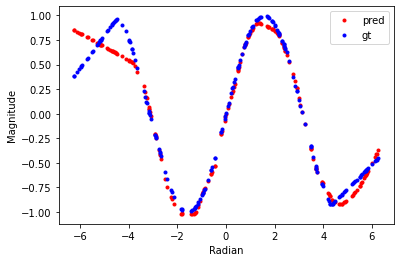

tensor([0.4000, 1.0000, 5.4978], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.016172654926776886


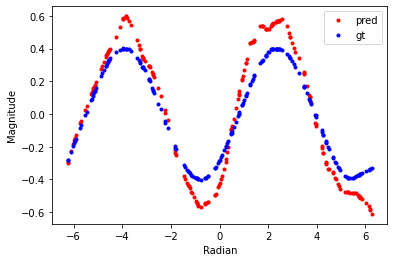

tensor([1.6000, 1.0000, 0.0000], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=0.0pi, pred loss=0.01915678195655346


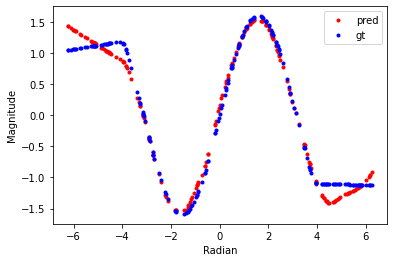

tensor([1.8000, 1.0000, 2.3562], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=0.75pi, pred loss=0.008045523427426815


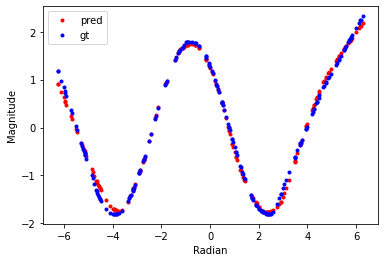

tensor([0.4000, 1.0000, 3.1416], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.0pi, pred loss=0.008843660354614258


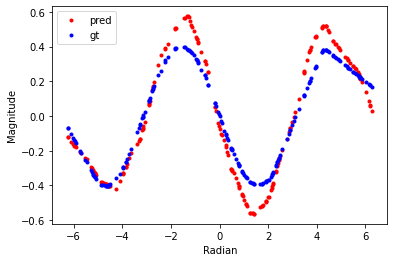

tensor([0.6000, 1.0000, 5.8905], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.8749998807907104pi, pred loss=0.01506256964057684


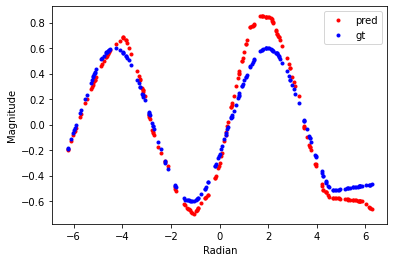

tensor([1.8000, 1.0000, 0.7854], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=0.25pi, pred loss=0.0097339553758502


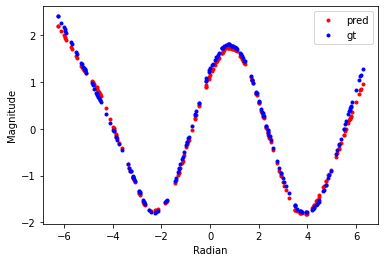

tensor([1.4000, 1.0000, 0.0000], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=0.0pi, pred loss=0.015111170709133148


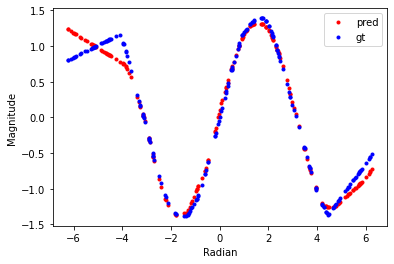

tensor([0.8000, 1.0000, 5.8905], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=1.8749998807907104pi, pred loss=0.009647720493376255


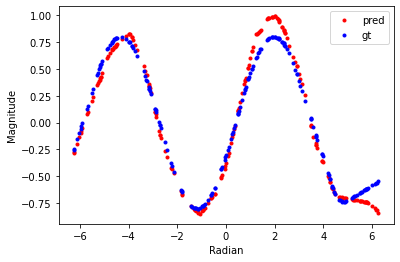

tensor([0.8000, 1.0000, 3.1416], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=1.0pi, pred loss=0.0035284659825265408


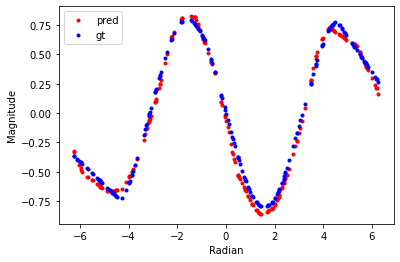

tensor([1.0000, 1.0000, 3.5343], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=1.125pi, pred loss=0.005722511559724808


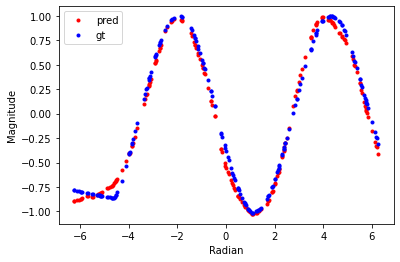

tensor([1.6000, 1.0000, 5.4978], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.007232059258967638


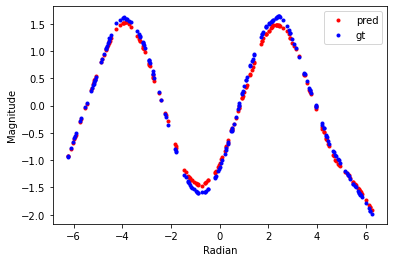

tensor([1.6000, 1.0000, 3.1416], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.0pi, pred loss=0.015149693936109543


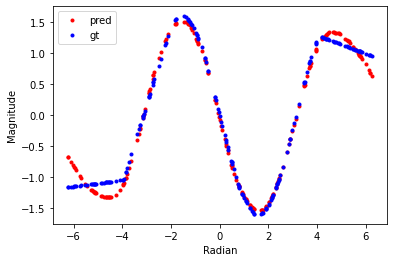

tensor([1.0000, 1.0000, 2.3562], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.75pi, pred loss=0.0027955928817391396


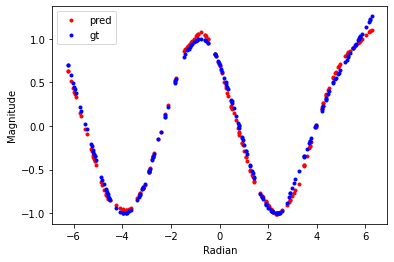

tensor([1.6000, 1.0000, 0.7854], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=0.25pi, pred loss=0.010194416157901287


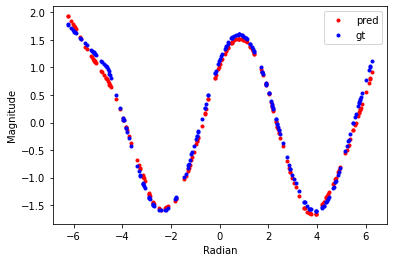

tensor([0.6000, 1.0000, 0.0000], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=0.0pi, pred loss=0.01132355909794569


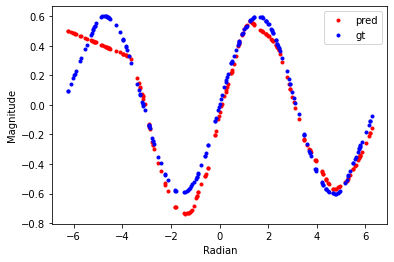

tensor([1.2000, 1.0000, 3.9270], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=1.2499998807907104pi, pred loss=0.005100181791931391


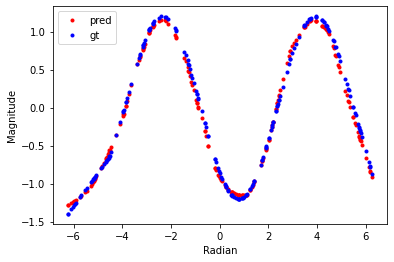

tensor([0.4000, 1.0000, 4.7124], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.5pi, pred loss=0.013051951304078102


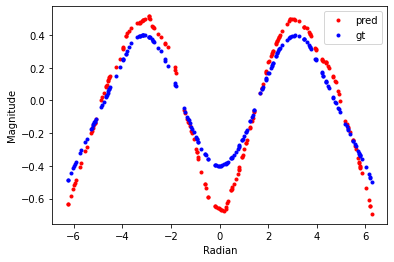

tensor([0.4000, 1.0000, 1.9635], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.6249999403953552pi, pred loss=0.009283225983381271


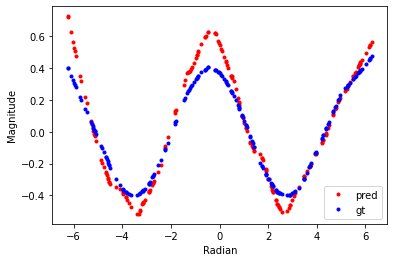

tensor([0.6000, 1.0000, 5.1051], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.625pi, pred loss=0.007992517203092575


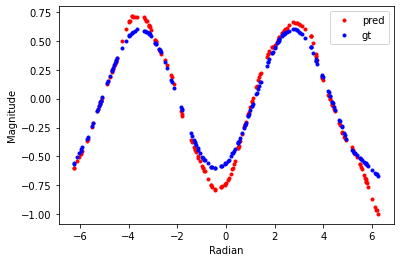

tensor([1.6000, 1.0000, 0.3927], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=0.125pi, pred loss=0.014153975062072277


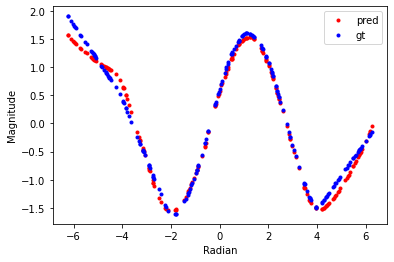

tensor([0.4000, 1.0000, 3.9270], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.2499998807907104pi, pred loss=0.009854940697550774


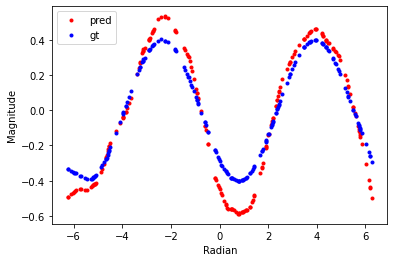

tensor([0.4000, 1.0000, 5.1051], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.625pi, pred loss=0.015147027559578419


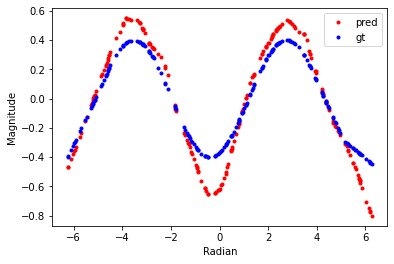

tensor([1.2000, 1.0000, 2.7489], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.004507150501012802


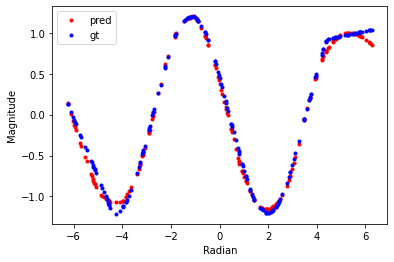

tensor([0.4000, 1.0000, 4.3197], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.013734969310462475


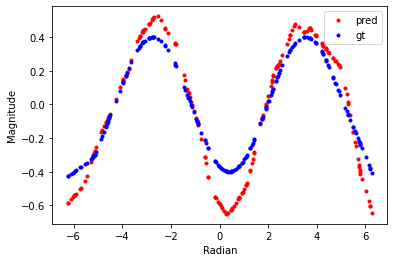

tensor([2.0000, 1.0000, 5.8905], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.8749998807907104pi, pred loss=0.0629664734005928


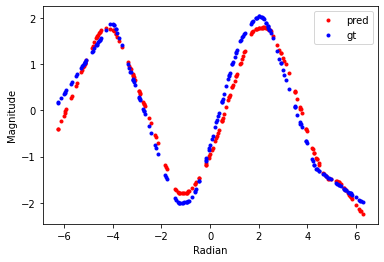

tensor([0.8000, 1.0000, 1.5708], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.5pi, pred loss=0.004193256609141827


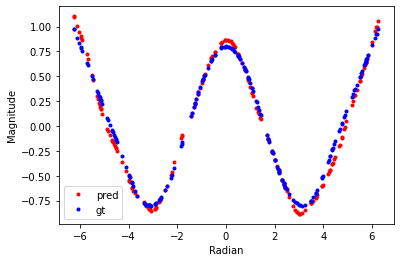

tensor([0.8000, 1.0000, 4.3197], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.0032912876922637224


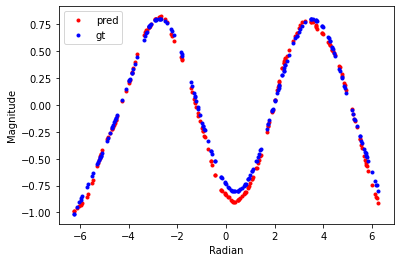

tensor([0.4000, 1.0000, 2.7489], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.007709343917667866


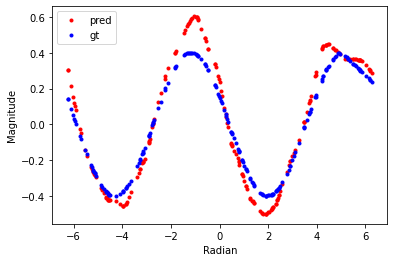

tensor([1.2000, 1.0000, 1.5708], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=0.5pi, pred loss=0.00289612403139472


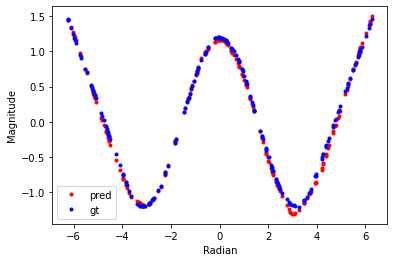

tensor([0.4000, 1.0000, 0.0000], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.0pi, pred loss=0.010326092131435871


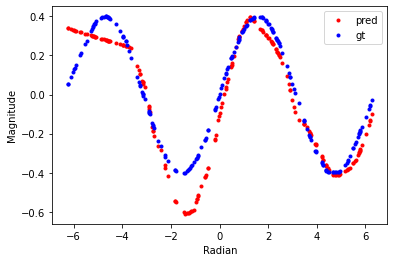

tensor([1.6000, 1.0000, 5.8905], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.8749998807907104pi, pred loss=0.015982791781425476


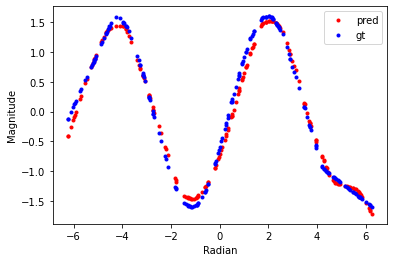

tensor([0.6000, 1.0000, 1.1781], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=0.375pi, pred loss=0.004718567710369825


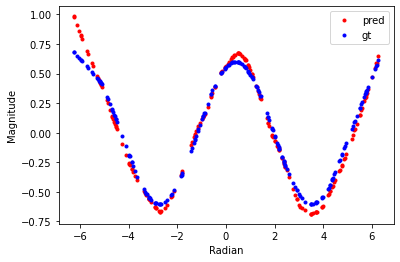

tensor([1.2000, 1.0000, 0.3927], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=0.125pi, pred loss=0.009282970800995827


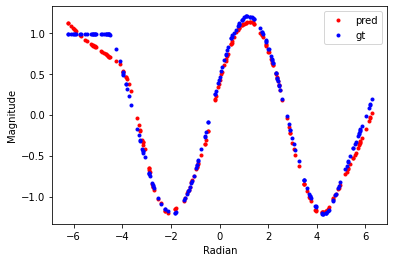

tensor([1.0000, 1.0000, 1.9635], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.6249999403953552pi, pred loss=0.0017471403116360307


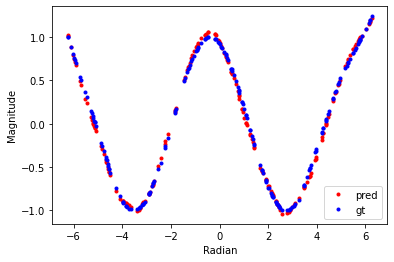

tensor([1.4000, 1.0000, 3.5343], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.125pi, pred loss=0.0049688685685396194


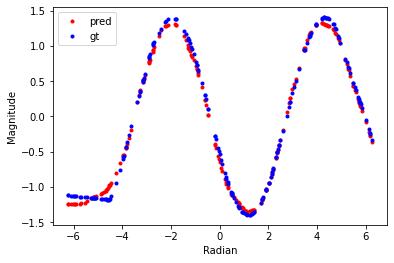

tensor([2.0000, 1.0000, 4.7124], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.5pi, pred loss=0.013469946570694447


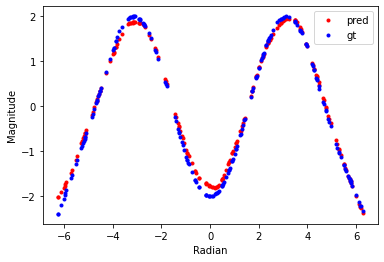

tensor([2.0000, 1.0000, 4.3197], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.01549063716083765


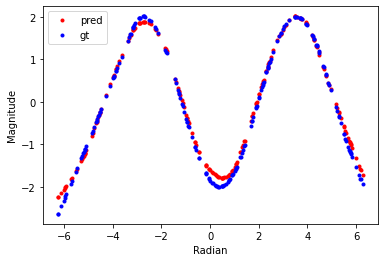

tensor([1.6000, 1.0000, 1.5708], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=0.5pi, pred loss=0.002262725029140711


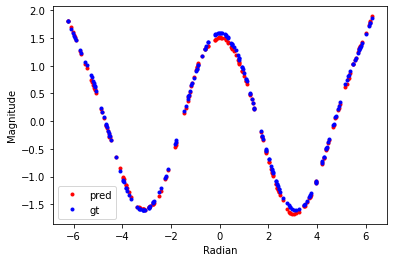

tensor([0.8000, 1.0000, 5.1051], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=1.625pi, pred loss=0.004467392340302467


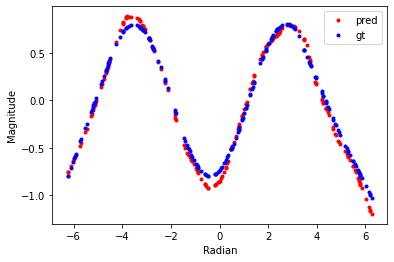

tensor([1.0000, 1.0000, 1.5708], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.5pi, pred loss=0.004717698320746422


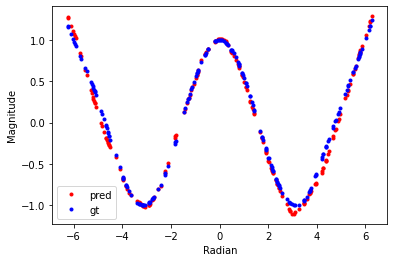

tensor([0.4000, 1.0000, 1.5708], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.5pi, pred loss=0.00938638485968113


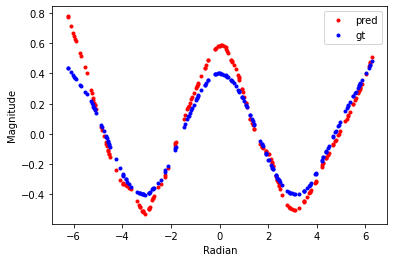

tensor([1.8000, 1.0000, 5.4978], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.017873011529445648


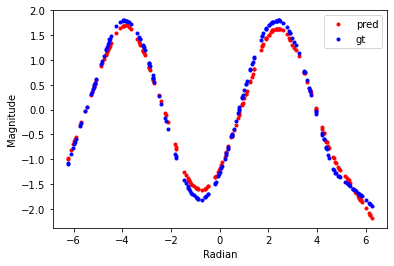

In [ ]:

tt_w = test_w_pred.clone().detach().cpu()

for t in range(test_batch_size):
  item = [test_a[:,t].float(), tt_w[:,t].float().unsqueeze(0), test_x[t,:].float(), test_y[t,:].float()]
  utils.taskVisualize(item, sineRegress, shape_record)


20
70
14
20
num of hp  25
rho for w_kb 0.1; mu for a_kb 0.1;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 11.918905258178711
1/3000 o_loss 65.80080915881055; m train metric 0.8466213409389768; m test metric 1.0139662340283395; align loss  0.06832599639892578
100/3000 o_loss 36.81801109441689; m train metric 0.8802486918866634; m test metric 0.991759417206049; align loss  0.061565399169921875
200/3000 o_loss 24.018967724272184; m train metric 0.8098780278648648; m test metric 0.9479391433298588; align loss  0.0670633316040039
300/3000 o_loss 16.740467392972537; m train metric 0.7215921857527323; m test metric 0.9282032690942288; align loss  0.05798625946044922
400/3000 o_loss 12.015216704990182; m train metric 0.665164622345141; m test metric 0.9550890915095807; align loss  0.0650491714477539
500/3000 o_loss 9.110770560268845; m train metric 0.9977

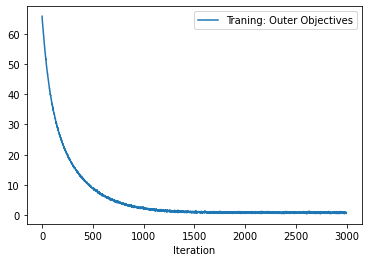

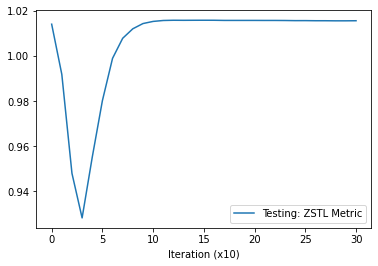

mean metric 1.0154980689287185
New best acc 1.0154980689287185
rho for w_kb 0.1; mu for a_kb 0.01;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 1.2596218585968018
1/3000 o_loss 65.59398185993943; m train metric 0.6403576289968831; m test metric 1.0141318246722222; align loss  0.0766603946685791
100/3000 o_loss 36.8700264436858; m train metric 0.9356510490179062; m test metric 0.9985405236482621; align loss  0.07176101207733154
200/3000 o_loss 24.07348532229662; m train metric 0.8688670237149511; m test metric 0.9565918706357479; align loss  0.0663294792175293
300/3000 o_loss 16.79165457668049; m train metric 0.7764757674719606; m test metric 0.9387208171188832; align loss  0.060863375663757324
400/3000 o_loss 12.187142091670207; m train metric 0.8429278052811111; m test metric 0.9603752054274083; align loss  0.06849384307861328
500/3000 o_loss 8.8

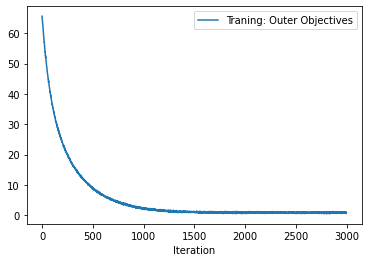

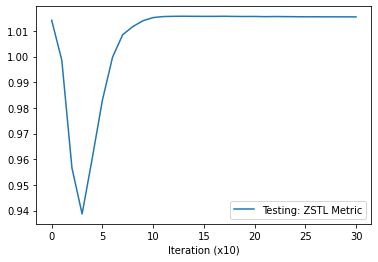

mean metric 1.0154266461730004
New best acc 1.0154266461730004
rho for w_kb 0.1; mu for a_kb 0.001;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.19369348883628845
1/3000 o_loss 65.88189124848161; m train metric 0.9278729802795819; m test metric 1.013959240913391; align loss  0.0690147876739502
100/3000 o_loss 36.6399553673608; m train metric 0.7040607572666236; m test metric 0.995402304828167; align loss  0.06412962824106216
200/3000 o_loss 24.00835733860731; m train metric 0.8036862324391092; m test metric 0.9587251655757427; align loss  0.05989064276218414
300/3000 o_loss 16.95019890261548; m train metric 0.933706479945353; m test metric 0.9312713883817196; align loss  0.061515651643276215
400/3000 o_loss 12.01390568379845; m train metric 0.666713786976678; m test metric 0.9599845759570599; align loss  0.0624774694442749
500/3000 o_loss 8.9901

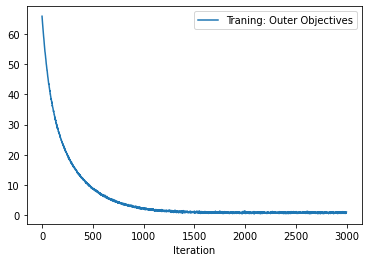

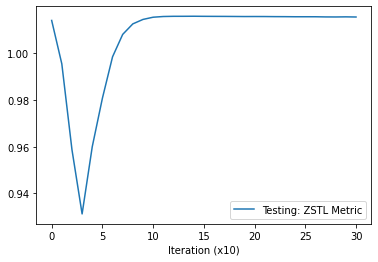

mean metric 1.0154293060302735
rho for w_kb 0.1; mu for a_kb 0.0001;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.08710065484046936
1/3000 o_loss 65.8911102350269; m train metric 0.9375064458165849; m test metric 1.0140007846057415; align loss  0.0761103704571724
100/3000 o_loss 37.06227182703359; m train metric 1.1255441084504128; m test metric 0.9904645502567292; align loss  0.06110089272260666
200/3000 o_loss 23.994245796331338; m train metric 0.7862438516957418; m test metric 0.9547396138310433; align loss  0.06952828168869019
300/3000 o_loss 16.832891139068774; m train metric 0.8157104429389749; m test metric 0.936805921047926; align loss  0.058616310358047485
400/3000 o_loss 12.219529134886605; m train metric 0.8724697280142988; m test metric 0.9574680857360364; align loss  0.06382030248641968
500/3000 o_loss 9.021115229598113; m train met

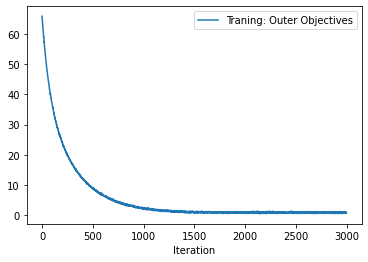

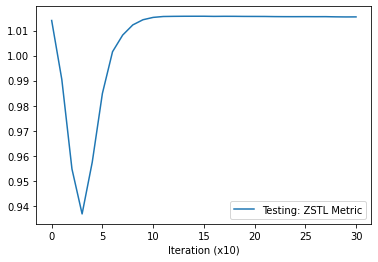

mean metric 1.015435840189457
rho for w_kb 0.1; mu for a_kb 1e-05;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.07644137740135193
1/3000 o_loss 65.87508192179459; m train metric 0.921125231044633; m test metric 1.0139524050056934; align loss  0.07016938179731369
100/3000 o_loss 36.82333105802536; m train metric 0.885850797274283; m test metric 0.9918290071189404; align loss  0.061661988496780396
200/3000 o_loss 23.998308904469013; m train metric 0.7878000794776848; m test metric 0.9428543835878372; align loss  0.06468195468187332
300/3000 o_loss 16.642311534179107; m train metric 0.6132026591471263; m test metric 0.92339843288064; align loss  0.06640006601810455
400/3000 o_loss 12.145822336098977; m train metric 0.7881818903344018; m test metric 0.9507643632590771; align loss  0.06223221495747566
500/3000 o_loss 9.004461689985224; m train metric

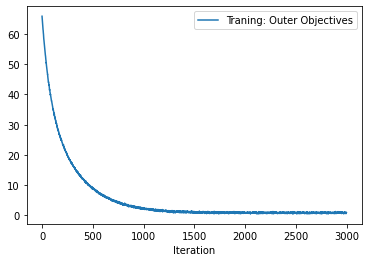

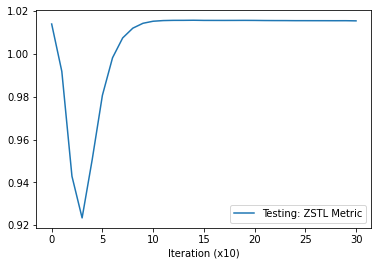

mean metric 1.0154236979782583
New best acc 1.0154236979782583
rho for w_kb 0.01; mu for a_kb 0.1;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 11.918905258178711
1/3000 o_loss 7.16109290931906; m train metric 0.6659645491412708; m test metric 1.0140784673392773; align loss  0.07638168334960938
100/3000 o_loss 4.570222690169301; m train metric 0.9448642714747361; m test metric 0.9211691193282605; align loss  0.06019878387451172
200/3000 o_loss 2.984826285392046; m train metric 0.5443240688847644; m test metric 0.5693307345733046; align loss  0.05680561065673828
300/3000 o_loss 2.2098010924777816; m train metric 0.41480764374136925; m test metric 0.41456545013934376; align loss  0.06192588806152344
400/3000 o_loss 1.6888369971088; m train metric 0.31243880851460354; m test metric 0.36236140104010706; align loss  0.06472015380859375
500/3000 o_loss 

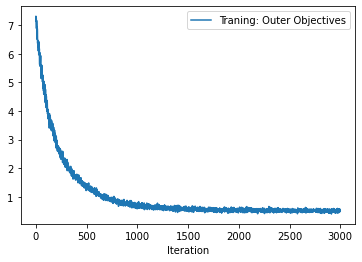

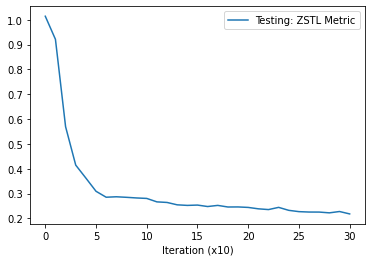

mean metric 0.21805301033891739
New best acc 0.21805301033891739
rho for w_kb 0.01; mu for a_kb 0.01;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 1.2596218585968018
1/3000 o_loss 7.537823746246951; m train metric 1.0424821190536022; m test metric 1.0139421679079532; align loss  0.07716989517211914
100/3000 o_loss 4.359549602227552; m train metric 0.7365565906677927; m test metric 0.9221956983208657; align loss  0.06346189975738525
200/3000 o_loss 2.9441356815929924; m train metric 0.5167535319924355; m test metric 0.6489739570766688; align loss  0.06146097183227539
300/3000 o_loss 2.128001170765076; m train metric 0.3357378292296614; m test metric 0.4213434075005353; align loss  0.05895543098449707
400/3000 o_loss 1.748697494821889; m train metric 0.37137853913009167; m test metric 0.3617668350227177; align loss  0.061110734939575195
500/3000 o_l

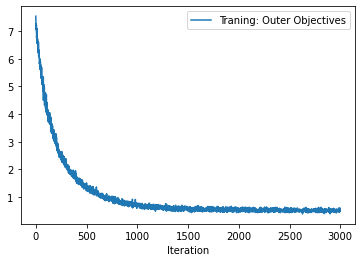

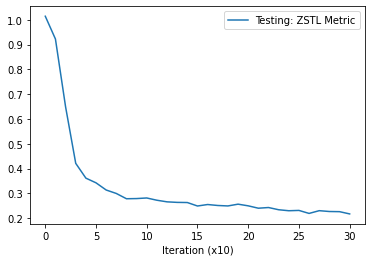

mean metric 0.2176039322279394
New best acc 0.2176039322279394
rho for w_kb 0.01; mu for a_kb 0.001;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.19369348883628845
1/3000 o_loss 7.64666713135583; m train metric 1.1513844983918327; m test metric 1.0139700591564178; align loss  0.07742923498153687
100/3000 o_loss 4.36120185096349; m train metric 0.7402385494538716; m test metric 0.9291083291172981; align loss  0.06674753874540329
200/3000 o_loss 2.97557033598423; m train metric 0.5532797117318425; m test metric 0.6595729563385249; align loss  0.058663398027420044
300/3000 o_loss 2.1211836133152246; m train metric 0.3454812480402844; m test metric 0.4553405800834298; align loss  0.0610581710934639
400/3000 o_loss 1.784721935567047; m train metric 0.41786838522447006; m test metric 0.36973957074806096; align loss  0.06194990873336792
500/3000 o_loss

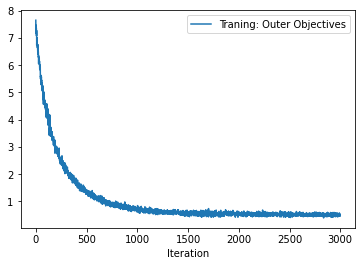

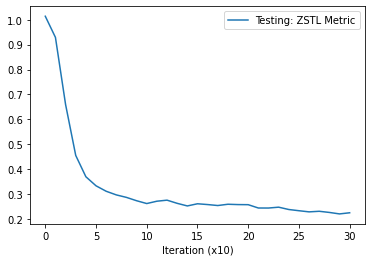

mean metric 0.22514897878281773
rho for w_kb 0.01; mu for a_kb 0.0001;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.08710065484046936
1/3000 o_loss 7.552562421986035; m train metric 1.056276264999594; m test metric 1.0138528160750866; align loss  0.06794325262308121
100/3000 o_loss 4.290539317365203; m train metric 0.6558712220617703; m test metric 0.8734510973095895; align loss  0.05920453369617462
200/3000 o_loss 2.858378539127963; m train metric 0.4115048527185406; m test metric 0.5825211483985185; align loss  0.062212951481342316
300/3000 o_loss 1.97572444232979; m train metric 0.19165685200797658; m test metric 0.4231096798554063; align loss  0.059613458812236786
400/3000 o_loss 1.670382808893919; m train metric 0.30189933641148464; m test metric 0.36162514965981246; align loss  0.062206584960222244
500/3000 o_loss 1.3878009468317032; m tra

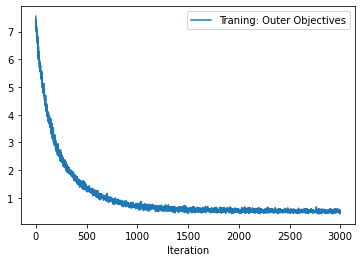

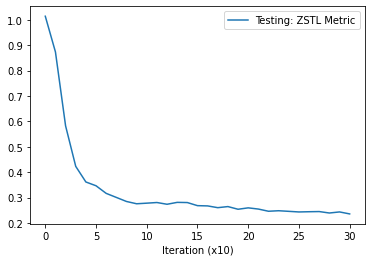

mean metric 0.2359447411261499
rho for w_kb 0.01; mu for a_kb 1e-05;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.07644137740135193
1/3000 o_loss 7.419785757682153; m train metric 0.9240267319338662; m test metric 1.0141911588609218; align loss  0.07536465674638748
100/3000 o_loss 4.361979629312243; m train metric 0.7429358794220856; m test metric 0.9437728628516198; align loss  0.059552427381277084
200/3000 o_loss 3.0791303259985785; m train metric 0.6643768527678081; m test metric 0.6803789153695107; align loss  0.0642966702580452
300/3000 o_loss 2.08496566010373; m train metric 0.3059706464409828; m test metric 0.4382726976647973; align loss  0.05749471113085747
400/3000 o_loss 1.6897447745182683; m train metric 0.3253115697630814; m test metric 0.37376320622861386; align loss  0.059204183518886566
500/3000 o_loss 1.2275095459605967; m train 

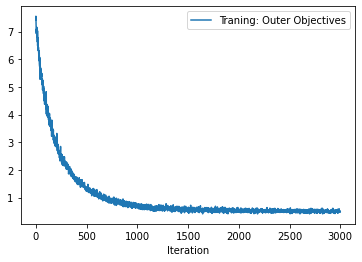

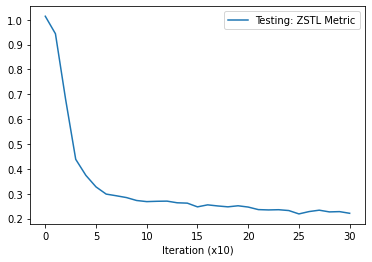

mean metric 0.2211363821756095
rho for w_kb 0.001; mu for a_kb 0.1;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 11.918905258178711
1/3000 o_loss 1.594079520021166; m train metric 0.9427399667246; m test metric 1.014311220496893; align loss  0.07075691223144531
100/3000 o_loss 0.8508454225957394; m train metric 0.42533391448003904; m test metric 0.6732419032603503; align loss  0.06194114685058594
200/3000 o_loss 0.5421624312709484; m train metric 0.19123870307313542; m test metric 0.17504794625565412; align loss  0.05481433868408203
300/3000 o_loss 0.3614101622785841; m train metric 0.07901446321713072; m test metric 0.09983079200610519; align loss  0.054167747497558594
400/3000 o_loss 0.28426448555131045; m train metric 0.047901528455050926; m test metric 0.07724932986311615; align loss  0.06205558776855469
500/3000 o_loss 0.2501946120256824; m t

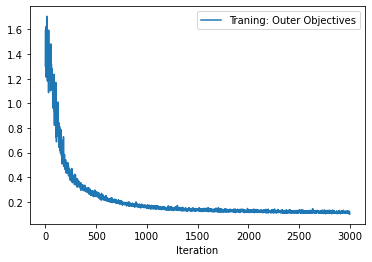

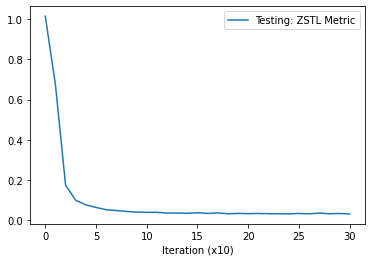

mean metric 0.032317923544906084
New best acc 0.032317923544906084
rho for w_kb 0.001; mu for a_kb 0.01;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 1.2596218585968018
1/3000 o_loss 1.430428892906223; m train metric 0.7802514109228338; m test metric 1.0142105951905251; align loss  0.07731592655181885
100/3000 o_loss 1.1897816942738635; m train metric 0.7965520585754088; m test metric 0.9284171789884568; align loss  0.0653454065322876
200/3000 o_loss 0.6027807287339653; m train metric 0.2710912746510335; m test metric 0.38885832857340574; align loss  0.06624972820281982
300/3000 o_loss 0.4252210286046777; m train metric 0.14063237833657435; m test metric 0.19403091669082642; align loss  0.05737006664276123
400/3000 o_loss 0.35758802188294275; m train metric 0.10453731885978153; m test metric 0.14286112315021457; align loss  0.059099435806274414
50

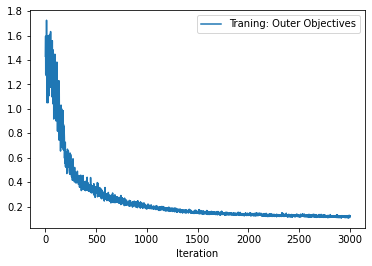

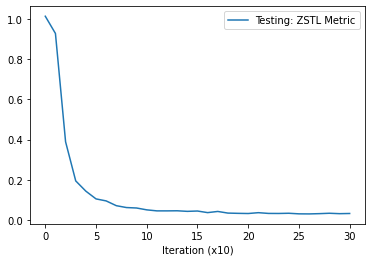

mean metric 0.03178359209559858
New best acc 0.03178359209559858
rho for w_kb 0.001; mu for a_kb 0.001;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.19369348883628845
1/3000 o_loss 1.6187267495053155; m train metric 0.9676928392478398; m test metric 1.0143622107803822; align loss  0.06962960958480835
100/3000 o_loss 1.0014843153102055; m train metric 0.5748734676412174; m test metric 0.6561057057231665; align loss  0.057046569883823395
200/3000 o_loss 0.4891196557187608; m train metric 0.13951258095247404; m test metric 0.1810717409476638; align loss  0.05287957191467285
300/3000 o_loss 0.3824752339028886; m train metric 0.09761406587702887; m test metric 0.1019314605742693; align loss  0.061839692294597626
400/3000 o_loss 0.31856085346745594; m train metric 0.08005827532282897; m test metric 0.080458717700094; align loss  0.057029008865356445
5

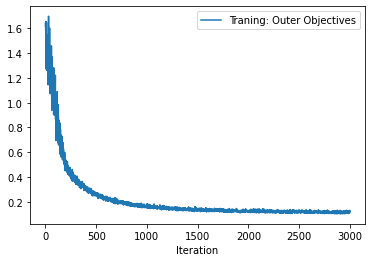

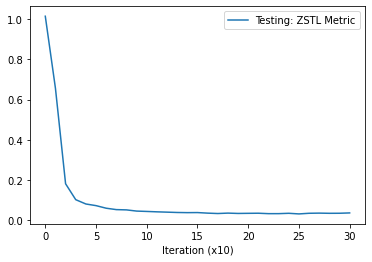

mean metric 0.03604112940374762
rho for w_kb 0.001; mu for a_kb 0.0001;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.08710065484046936
1/3000 o_loss 1.8351806976965495; m train metric 1.1848435678652354; m test metric 1.0135155208408833; align loss  0.07235866039991379
100/3000 o_loss 0.9595545833664281; m train metric 0.5325494264917714; m test metric 0.6824956614524127; align loss  0.05858475714921951
200/3000 o_loss 0.5084534942039421; m train metric 0.16069715310420307; m test metric 0.1716906774789095; align loss  0.05915307253599167
300/3000 o_loss 0.36630425449194653; m train metric 0.07918971331257905; m test metric 0.09185189683921635; align loss  0.05657584220170975
400/3000 o_loss 0.3043056504933962; m train metric 0.06588369434965508; m test metric 0.07538404227234424; align loss  0.053176987916231155
500/3000 o_loss 0.24413446895778

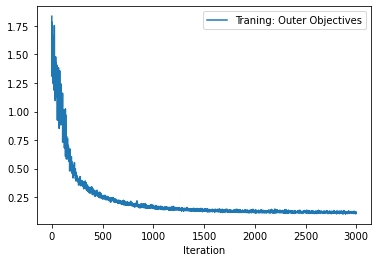

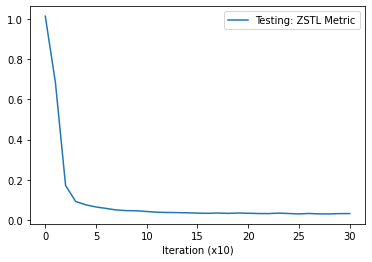

mean metric 0.03196654693456367
rho for w_kb 0.001; mu for a_kb 1e-05;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.07644137740135193
1/3000 o_loss 1.460707870445081; m train metric 0.8095963751631123; m test metric 1.0151790477335454; align loss  0.07707391679286957
100/3000 o_loss 0.7529807080115591; m train metric 0.3437652622482606; m test metric 0.8704266101121902; align loss  0.05973099544644356
200/3000 o_loss 0.6274824876870428; m train metric 0.2875513226858207; m test metric 0.33232301063835623; align loss  0.06866414099931717
300/3000 o_loss 0.4306177015283278; m train metric 0.14174602340374673; m test metric 0.19864696068689228; align loss  0.06239698827266693
400/3000 o_loss 0.36654161954564707; m train metric 0.11427932365664413; m test metric 0.1268106380943209; align loss  0.05990045145153999
500/3000 o_loss 0.3361979106308094; 

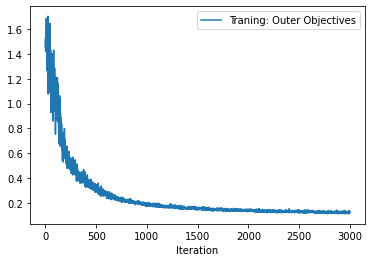

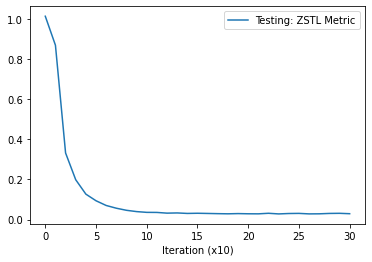

mean metric 0.02911362040322274
New best acc 0.02911362040322274
rho for w_kb 0.0001; mu for a_kb 0.1;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 11.918905258178711
1/3000 o_loss 1.0708645571555409; m train metric 1.004450068942138; m test metric 1.0142033353447915; align loss  0.06982135772705078
100/3000 o_loss 0.5711935928889683; m train metric 0.5060149468481541; m test metric 0.5719779416918754; align loss  0.057323455810546875
200/3000 o_loss 0.169884110933968; m train metric 0.10999442104782377; m test metric 0.12588316826149823; align loss  0.059322357177734375
300/3000 o_loss 0.11188631724300128; m train metric 0.054661801018353016; m test metric 0.06512831090949477; align loss  0.06008434295654297
400/3000 o_loss 0.0766578777693212; m train metric 0.024757315537759235; m test metric 0.04465328357182444; align loss  0.058121681213378906

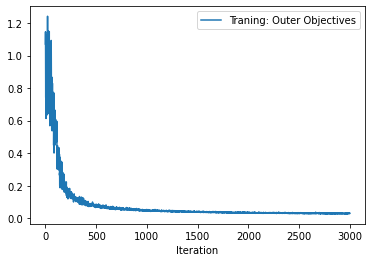

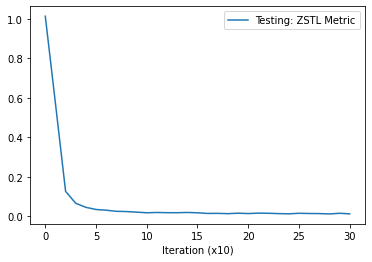

mean metric 0.011700991168618204
New best acc 0.011700991168618204
rho for w_kb 0.0001; mu for a_kb 0.01;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 1.2596218585968018
1/3000 o_loss 0.7211141187165464; m train metric 0.6535250853214944; m test metric 1.0158547170460224; align loss  0.06893372535705566
100/3000 o_loss 0.613530659782035; m train metric 0.5557107840265546; m test metric 0.8560021184384823; align loss  0.07366526126861572
200/3000 o_loss 0.22825287495340618; m train metric 0.16691370813974313; m test metric 0.27464266046881675; align loss  0.0646439790725708
300/3000 o_loss 0.1655365770150508; m train metric 0.10365951926048313; m test metric 0.1258582841604948; align loss  0.06942451000213623
400/3000 o_loss 0.12284508251052882; m train metric 0.06455221203421907; m test metric 0.08127384770195932; align loss  0.07002687454223633
5

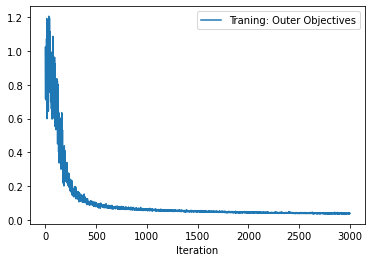

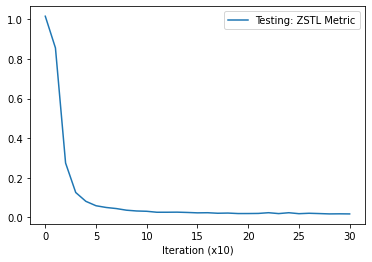

mean metric 0.017755899945041165
rho for w_kb 0.0001; mu for a_kb 0.001;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.19369348883628845
1/3000 o_loss 1.066905182919332; m train metric 0.9970156507832663; m test metric 1.0159222312271596; align loss  0.06821981072425842
100/3000 o_loss 0.7067131152642624; m train metric 0.6474911006433622; m test metric 0.7906848929822445; align loss  0.07253038138151169
200/3000 o_loss 0.2662236610693591; m train metric 0.20901840845389025; m test metric 0.26081429943442347; align loss  0.07127843797206879
300/3000 o_loss 0.14826489545937094; m train metric 0.09231924691370555; m test metric 0.14029375216923654; align loss  0.06585026532411575
400/3000 o_loss 0.10848993927772556; m train metric 0.05267373951418059; m test metric 0.08318915036506952; align loss  0.06685417890548706
500/3000 o_loss 0.0907554765497

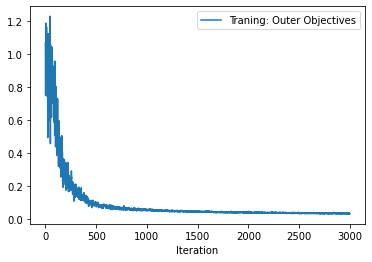

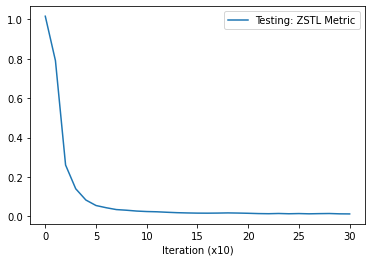

mean metric 0.012690239434596151
rho for w_kb 0.0001; mu for a_kb 0.0001;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.08710065484046936
1/3000 o_loss 1.056513199848788; m train metric 0.9890615524990217; m test metric 1.0131206445395946; align loss  0.07584000378847122
100/3000 o_loss 1.0202879799263818; m train metric 0.9601187003510339; m test metric 0.8376262933015823; align loss  0.06343161314725876
200/3000 o_loss 0.394911141933075; m train metric 0.33232895803770846; m test metric 0.3660912044346333; align loss  0.05966997146606445
300/3000 o_loss 0.19971745906929883; m train metric 0.13270889561889426; m test metric 0.14734782320447268; align loss  0.060922130942344666
400/3000 o_loss 0.11898966802151076; m train metric 0.05086027594682361; m test metric 0.09443808645009995; align loss  0.06972503662109375
500/3000 o_loss 0.1036314903093

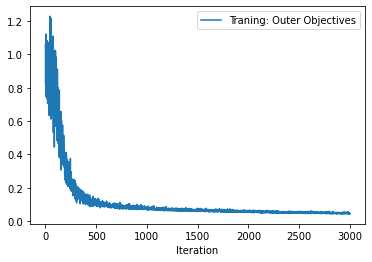

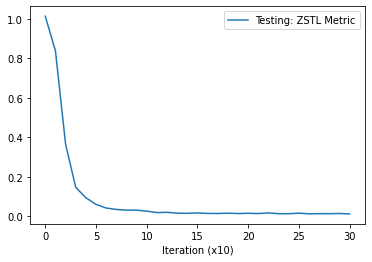

mean metric 0.012594054074725136
rho for w_kb 0.0001; mu for a_kb 1e-05;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.07644137740135193
1/3000 o_loss 0.6989437607782227; m train metric 0.6309778323130948; m test metric 1.0148693010210992; align loss  0.06314324587583542
100/3000 o_loss 0.7357585854562265; m train metric 0.6688513682622994; m test metric 0.5938729900866747; align loss  0.060750167816877365
200/3000 o_loss 0.17140455118247439; m train metric 0.11330747404800993; m test metric 0.1460267560556531; align loss  0.06025758013129234
300/3000 o_loss 0.12735718827960746; m train metric 0.07324892967673284; m test metric 0.07279350301250816; align loss  0.05750162526965141
400/3000 o_loss 0.08578622111651514; m train metric 0.035802777856588364; m test metric 0.0505427263211459; align loss  0.05007163807749748
500/3000 o_loss 0.07189185671

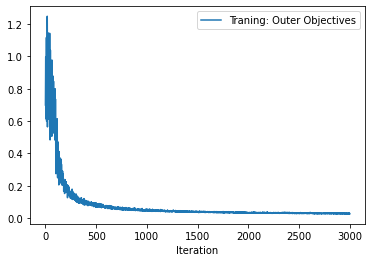

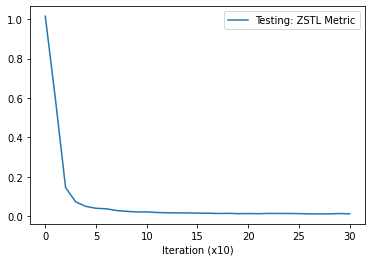

mean metric 0.012925154622644187
rho for w_kb 1e-05; mu for a_kb 0.1;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 11.918905258178711
1/3000 o_loss 0.8530976477611277; m train metric 0.8443127082926886; m test metric 1.0129461281001568; align loss  0.0737752914428711
100/3000 o_loss 0.5015100686411772; m train metric 0.48832375609448975; m test metric 0.6349071688950062; align loss  0.06473255157470703
200/3000 o_loss 0.14427498348855547; m train metric 0.13400537773434604; m test metric 0.1420111855491996; align loss  0.06344032287597656
300/3000 o_loss 0.07782663804079805; m train metric 0.07019658040787492; m test metric 0.06753512173891067; align loss  0.0592193603515625
400/3000 o_loss 0.04403466445260814; m train metric 0.03614170929150922; m test metric 0.04891499066725374; align loss  0.059266090393066406
500/3000 o_loss 0.0308146436831780

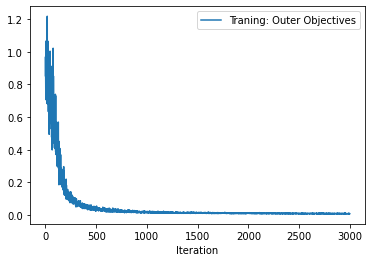

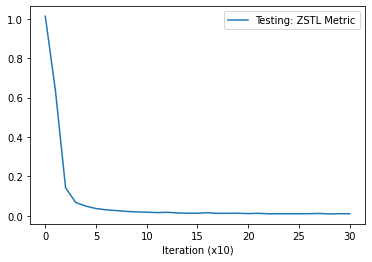

mean metric 0.010283547529252247
New best acc 0.010283547529252247
rho for w_kb 1e-05; mu for a_kb 0.01;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 1.2596218585968018
1/3000 o_loss 0.8439069356370185; m train metric 0.834338190300124; m test metric 1.0159437648952008; align loss  0.06638896465301514
100/3000 o_loss 0.5921207194748733; m train metric 0.5768198453422103; m test metric 0.7796099647879601; align loss  0.07099831104278564
200/3000 o_loss 0.17101520047123941; m train metric 0.16234721110335418; m test metric 0.254697812628001; align loss  0.07945549488067627
300/3000 o_loss 0.08516623339216624; m train metric 0.07603433754827295; m test metric 0.11000175457447768; align loss  0.06470239162445068
400/3000 o_loss 0.05740562470496765; m train metric 0.04878610854835382; m test metric 0.06674811160191894; align loss  0.06695997714996338
5

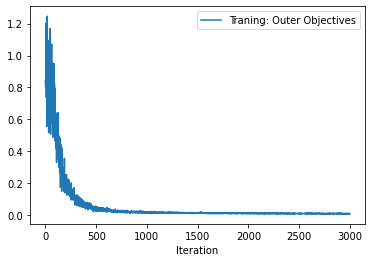

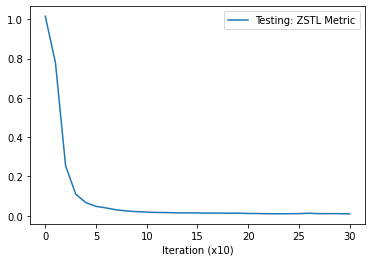

mean metric 0.009414493018994108
New best acc 0.009414493018994108
rho for w_kb 1e-05; mu for a_kb 0.001;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.19369348883628845
1/3000 o_loss 1.0441357007117142; m train metric 1.0363406475101198; m test metric 1.0158349953591823; align loss  0.07185329496860504
100/3000 o_loss 0.38395921407001354; m train metric 0.3718752161200557; m test metric 0.5863057132810354; align loss  0.057774968445301056
200/3000 o_loss 0.13014006528205105; m train metric 0.12131227646023035; m test metric 0.13173908274620771; align loss  0.060854554176330566
300/3000 o_loss 0.08359200999672924; m train metric 0.07630495939935956; m test metric 0.06508046174421907; align loss  0.05858733505010605
400/3000 o_loss 0.05263435860563601; m train metric 0.0450881581221308; m test metric 0.050137431500479585; align loss  0.05560208857

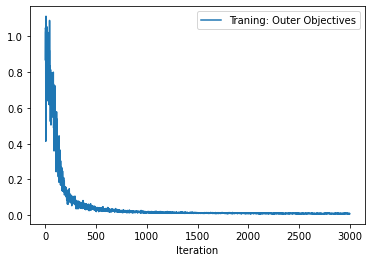

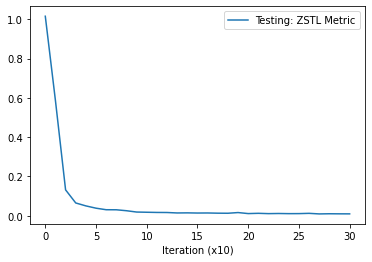

mean metric 0.009567155520198867
rho for w_kb 1e-05; mu for a_kb 0.0001;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.08710065484046936
1/3000 o_loss 0.9485607916888381; m train metric 0.9392967277339526; m test metric 1.0158366836607458; align loss  0.07479805499315262
100/3000 o_loss 0.5404563688540033; m train metric 0.531108819214361; m test metric 0.8360690142959357; align loss  0.0660226047039032
200/3000 o_loss 0.239512846339494; m train metric 0.22831449045666624; m test metric 0.38450390845537186; align loss  0.07176817953586578
300/3000 o_loss 0.12141057157090732; m train metric 0.11063902918249369; m test metric 0.1778466656804085; align loss  0.07803807407617569
400/3000 o_loss 0.07300751988909074; m train metric 0.06339039986154862; m test metric 0.10013364674523473; align loss  0.071767657995224
500/3000 o_loss 0.04709897226920085;

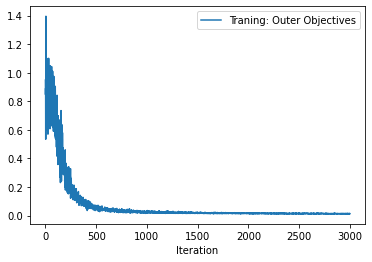

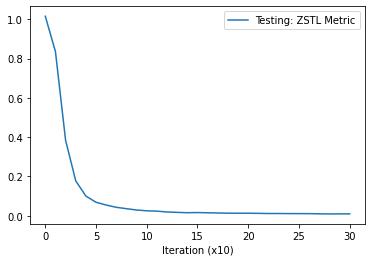

mean metric 0.00969563355029095
rho for w_kb 1e-05; mu for a_kb 1e-05;
test  torch.Size([3, 20]) torch.Size([1761, 20]) torch.Size([20, 200, 1]) torch.Size([20, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 1.0139400012791158; align loss 0.07644137740135193
1/3000 o_loss 0.8526240936480463; m train metric 0.8442919158509798; m test metric 1.0138506889343262; align loss  0.0660688579082489
100/3000 o_loss 0.4894242035890264; m train metric 0.47496436509702883; m test metric 0.5846239928156137; align loss  0.058260854333639145
200/3000 o_loss 0.10256078034373266; m train metric 0.09438723458775451; m test metric 0.13153871977701784; align loss  0.062001001089811325
300/3000 o_loss 0.04002980036394937; m train metric 0.03298440921519483; m test metric 0.06933395508676768; align loss  0.05732225999236107
400/3000 o_loss 0.05535304606226938; m train metric 0.049122067966631475; m test metric 0.04659735071472824; align loss  0.059056684374809265
500/3000 o_loss 0.024590598

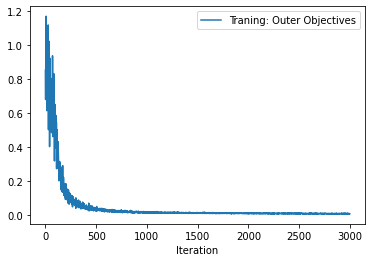

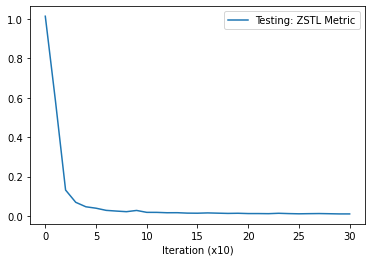

mean metric 0.010378344735363499
best_hp  {'mu': 0.01, 'rho': 1e-05}


In [ ]:
indx = train_indx
val_indx = list(np.random.choice(indx, size=20, replace=False))
print(len(val_indx))
train_indx_splited = [x for x in indx if x not in val_indx]
print(len(train_indx_splited))

val_data = utils.Dataset([dataset[d] for d in val_indx])
train_splited_data = utils.Dataset([dataset[d] for d in train_indx_splited])
val_loader = DataLoader(val_data, batch_size=int(len(val_indx)), shuffle=True)
train_splited_loader = DataLoader(train_splited_data, batch_size=int(len(train_indx_splited)/5), shuffle=True)

best_hp = utils.hp_select_regression(train_splited_loader, val_loader, support_loader, 1761, dm, sineRegress, shape_record, device, val_step=3000)
print('best_hp ', best_hp)

In [ ]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
d = support_w.size()[0]
print(dm)
print(d)

param_dict = {}
param_dict['rho'] = best_hp['rho']
param_dict['mu'] = best_hp['mu']
param_dict['loss'] = 'mse'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = 1761
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Softmax'
print(param_dict)


ZSTL_model = ZSTL(support_w, support_a, sineRegress, param_dict, device)
ZSTL_model.train(train_loader, test_loader, max_iter=4000)


3
1761
{'rho': 1e-05, 'mu': 0.01, 'loss': 'mse', 'outer lr': 0.001, 'align lr': 0.0001, 'dm': 3, 'd': 1761, 'model_shape': {0: [(40, 1)], 1: [(40,)], 2: [(40, 40)], 3: [(40,)], 4: [(1, 40)], 5: [(1,)]}, 'atten_activation': 'Softmax'}
softmax selected
test  torch.Size([3, 44]) torch.Size([1761, 44]) torch.Size([44, 200, 1]) torch.Size([44, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 0.6983900993046436; align loss 1.2556588649749756
1/4000 o_loss 1.0037256604991853; m train metric 0.9946584138605329; m test metric 0.6966926553709941; align loss  0.07111752033233643
100/4000 o_loss 1.1864505689073768; m train metric 1.1781043484807014; m test metric 0.6756070332432336; align loss  0.06768989562988281
200/4000 o_loss 0.49954239563602537; m train metric 0.48516169055882424; m test metric 0.3495186623185873; align loss  0.07262325286865234
300/4000 o_loss 0.18116486300196913; m train metric 0.17172569471100965; m test metric 0.19417874227193269; align loss  0.06292176246

In [ ]:
def genSplits(dataset_split, train_size, test_size, support_size, T, train_batch_size=140):
    indx = [ x for x in range(len(dataset_split))]
    support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
    print(len(support_indx))
    temp = [x for x in indx if x not in support_indx]
    train_indx = list(np.random.choice(temp, size=train_size, replace=False))
    temp = [x for x in temp if x not in train_indx]
    print(len(train_indx))
    test_indx = temp
    print(len(test_indx))


    support_data = utils.Dataset([dataset_split[d] for d in support_indx])
    train_data = utils.Dataset([dataset_split[d] for d in train_indx])
    test_data = utils.Dataset([dataset_split[d] for d in test_indx])

    support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
    train_loader = DataLoader(train_data, batch_size=int(train_batch_size/5), shuffle=True)
    test_loader = DataLoader(test_data, batch_size=int(test_size), shuffle=True)

    return support_loader, train_loader, test_loader

train_size1 = 90
test_size1 = 44
support_size1 = 10
support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, len(dataset), train_batch_size=train_size1)

In [ ]:
exp_results = []
Run = 10
print(param_dict)
for r in range(Run):
    support_loader, train_loader, test_loader = genSplits(dataset, train_size1, test_size1, support_size1, len(dataset), train_batch_size=train_size1)
    support_a, support_w, support_x, support_y = next(iter(support_loader))
    support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
    support_a = support_a.squeeze().t()
    support_w = support_w.squeeze().t()
    ZSTL_model = ZSTL(support_w, support_a, sineRegress, param_dict, device)
    ZSTL_model.train(train_loader, test_loader, max_iter=4000)
    mean_acc = ZSTL_model.zero_shot_transfer(test_loader)
    print('mean acc ', mean_acc)
    exp_results.append(utils.toNumpy(mean_acc.cpu()))


In [ ]:
import scipy
from scipy import stats
print(exp_results)
sample = np.array(exp_results)
confidence_level = 0.95
degrees_freedom = sample.size - 1
sample_mean = np.mean(sample)
sample_standard_error = scipy.stats.sem(sample)

confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
print(sample_mean)
print(confidence_interval)
print(confidence_interval - sample_mean)

In [ ]:
print(param_dict)

#Show the effectiviness of ZSTL by plotting sine wave with different runs meta-update

In [ ]:
filename = 'sineWave_xl.p'
with open(filename, 'rb') as f:
    dataset = pickle.load(f)
total_len = len(dataset)
test_size = total_len - kb_size - train_size

flatted_param, shape_record = utils.flattenParam(dataset[0])
print(shape_record)

indx = [ x for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
test_indx = temp
print(len(test_indx))

support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])

support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=int(train_size/5), shuffle=True)
test_loader = DataLoader(test_data, batch_size=int(test_size), shuffle=True)

support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()

{0: [(40, 1)], 1: [(40,)], 2: [(40, 40)], 3: [(40,)], 4: [(1, 40)], 5: [(1,)]}
10
90
44


In [ ]:
runs_lst = [1, 500, 1500, 2500]

In [ ]:

support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
print(support_a.size())
dm = support_a.size()[0]

param_dict = {}
param_dict['rho'] = 1e-5
param_dict['mu'] = 0.0001
param_dict['loss'] = 'mse'
param_dict['outer lr'] = 5e-4
param_dict['align lr'] = 5e-4
param_dict['dm'] = dm
param_dict['d'] = 1761
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Softmax'

test_batch = next(iter(test_loader))
test_a, test_w, test_x, test_y = test_batch[0].float(), test_batch[1].float(), \
    test_batch[2].float(), test_batch[3].float()

yy = test_a[0, :][0,0] * torch.sin(test_a[0, :][0,1]*test_x[0,:] + test_a[0, :][0,2])

test_a = test_a.squeeze().t().to(device)
test_w = test_w.squeeze().t()

torch.Size([3, 10])


softmax selected
test  torch.Size([3, 44]) torch.Size([1761, 44]) torch.Size([44, 200, 1]) torch.Size([44, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 0.7739414735273882; align loss 0.07750014960765839
1/1 o_loss 0.8899864441094298; m train metric 0.8819782175123692; m test metric 0.7737422284077514; align loss  0.0678265243768692
lr  0.0005


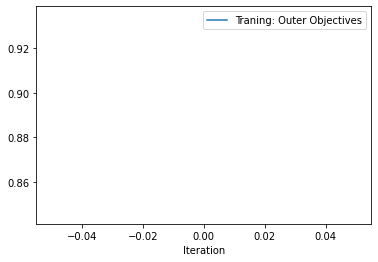

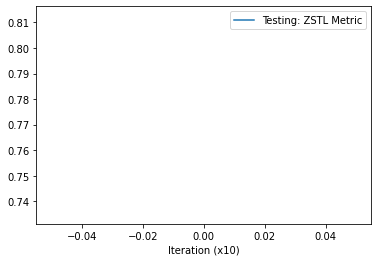

tensor([1.6000, 1.0000, 4.7124], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.5pi, pred loss=1.2780152559280396


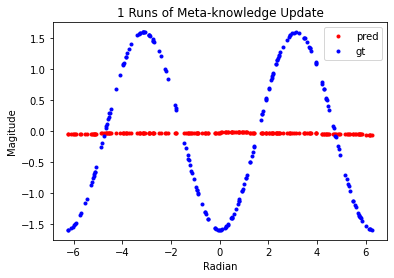

test  torch.Size([3, 44]) torch.Size([1761, 44]) torch.Size([44, 200, 1]) torch.Size([44, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 0.7739414735273882; align loss 0.07750014960765839
1/500 o_loss 0.7486040093936026; m train metric 0.7412247554295592; m test metric 0.7735065597702157; align loss  0.05958766117691994
200/500 o_loss 0.6467647058371868; m train metric 0.6376942507922649; m test metric 0.5950015776113353; align loss  0.05192064493894577
400/500 o_loss 0.15915927394396728; m train metric 0.14954266593688062; m test metric 0.2348468873057176; align loss  0.04628037288784981
lr  0.0005


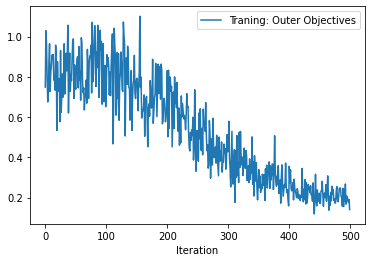

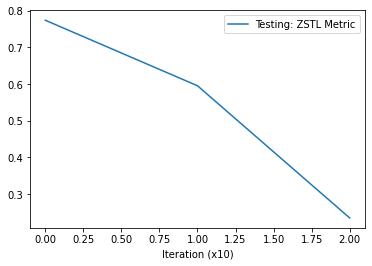

tensor([1.6000, 1.0000, 4.7124], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.5pi, pred loss=0.16804799437522888


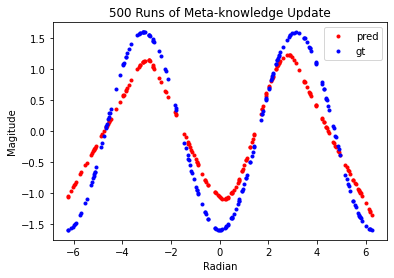

test  torch.Size([3, 44]) torch.Size([1761, 44]) torch.Size([44, 200, 1]) torch.Size([44, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 0.7739414735273882; align loss 0.07750014960765839
1/1500 o_loss 0.8036678154538902; m train metric 0.7962470861772696; m test metric 0.7735049704259093; align loss  0.06671267747879028
200/1500 o_loss 0.46254839603271747; m train metric 0.4540521746708287; m test metric 0.5483871976506304; align loss  0.052996762096881866
400/1500 o_loss 0.2163840809630023; m train metric 0.20674620423879886; m test metric 0.24981775524264033; align loss  0.04946427419781685
600/1500 o_loss 0.1614438256041871; m train metric 0.1525030367904239; m test metric 0.17328455519269814; align loss  0.049646660685539246
800/1500 o_loss 0.1634571859613061; m train metric 0.15378895665829379; m test metric 0.14330476257865402; align loss  0.04715949669480324
1000/1500 o_loss 0.09687814737359682; m train metric 0.087168223845462; m test metric 0.111388198830271

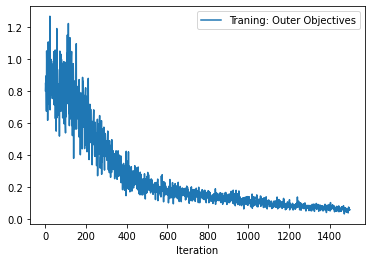

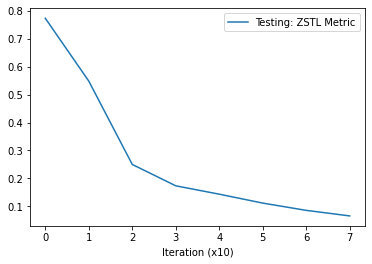

tensor([1.6000, 1.0000, 4.7124], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.5pi, pred loss=0.041574086993932724


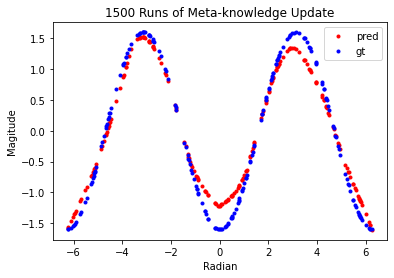

test  torch.Size([3, 44]) torch.Size([1761, 44]) torch.Size([44, 200, 1]) torch.Size([44, 200, 1])
weight_kb  torch.Size([1761, 10])
init mean test metric 0.7739414735273882; align loss 0.07750014960765839
1/2500 o_loss 1.000560214794758; m train metric 0.9926696895725197; m test metric 0.7736416155980392; align loss  0.05651520565152168
200/2500 o_loss 0.5959058058862057; m train metric 0.5865002601510948; m test metric 0.5606337022036314; align loss  0.053687140345573425
400/2500 o_loss 0.2154753848703371; m train metric 0.2063727563040124; m test metric 0.2494178620082411; align loss  0.05166963115334511
600/2500 o_loss 0.15505578617254892; m train metric 0.14625145763986638; m test metric 0.17423713905736804; align loss  0.044779904186725616
800/2500 o_loss 0.16448451221610108; m train metric 0.15518873885998294; m test metric 0.14287804589945485; align loss  0.046684395521879196
1000/2500 o_loss 0.1484598894086149; m train metric 0.13852174466268882; m test metric 0.11399548300753

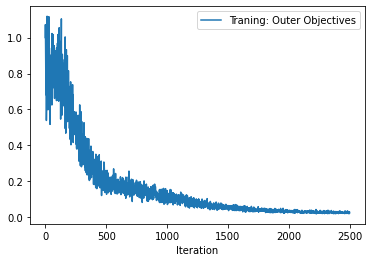

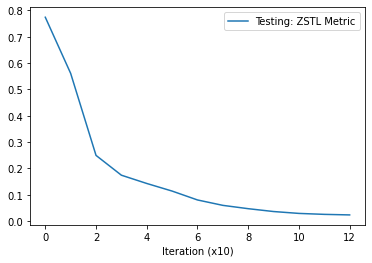

tensor([1.6000, 1.0000, 4.7124], device='cuda:0')
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.5pi, pred loss=0.011410504579544067


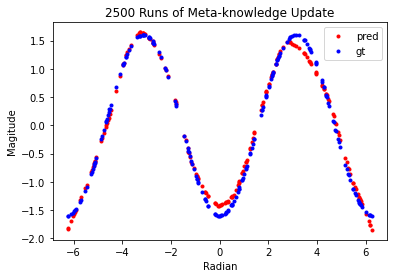

In [ ]:
ZSTL_model = ZSTL(support_w, support_a,  sineRegress, param_dict, device=device)

for r in runs_lst:
  ZSTL_model.init()
  ZSTL_model.train(train_loader, test_loader, max_iter=r)
  test_w_pred = ZSTL_model.task_transfer(test_a)
  test_batch_size = test_w_pred.size()[1]
  tt_w = test_w_pred.clone().detach().cpu()
  
  item = [test_a[:,0].float(), tt_w[:,0].float().unsqueeze(0), test_x[0,:].float(), yy.float()]
  str_title = '{} Runs of Meta-knowledge Update'.format(r)
  utils.taskVisualize(item, sineRegress, shape_record, tag=str_title)